# Import Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check out the Data

## Training data

In [2]:
train_data_raw = pd.read_csv('../input/1102-mds603-machine-learning/train_data.csv')
train_data_raw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,24627684,Quaint NYC studio- tree lined St.- great locat...,47895481,Omar,Manhattan,Midtown,40.74460,-73.98399,Entire home/apt,175,1,2,2018-07-02,0.16,1,0
1,30670056,Sunny Williamsburg Loft ☀️,14559352,Jamis,Brooklyn,Williamsburg,40.71064,-73.96140,Entire home/apt,150,3,4,2019-03-23,0.63,2,0
2,4917122,Beautiful 1 br Williamsburg apt,4445005,Jamaal,Brooklyn,Williamsburg,40.71281,-73.96570,Entire home/apt,200,2,3,2018-08-30,0.10,1,16
3,23292216,Lower East Side Oasis,173406651,Dan,Manhattan,Lower East Side,40.71960,-73.98133,Entire home/apt,300,3,30,2019-07-02,1.77,2,182
4,34751491,Cozy private room,262079510,Karmelle,Brooklyn,Bedford-Stuyvesant,40.68939,-73.92564,Private room,80,2,5,2019-06-20,2.88,1,83


In [3]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31292 entries, 0 to 31291
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              31292 non-null  int64  
 1   name                            31282 non-null  object 
 2   host_id                         31292 non-null  int64  
 3   host_name                       31279 non-null  object 
 4   neighbourhood_group             31292 non-null  object 
 5   neighbourhood                   31292 non-null  object 
 6   latitude                        31292 non-null  float64
 7   longitude                       31292 non-null  float64
 8   room_type                       31292 non-null  object 
 9   price                           31292 non-null  int64  
 10  minimum_nights                  31292 non-null  int64  
 11  number_of_reviews               31292 non-null  int64  
 12  last_review                     

In [4]:
train_data_raw.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.129200e+04,3.129200e+04,31292.000000,31292.000000,31292.000000,31292.000000,31292.000000,24751.000000,31292.000000,31292.000000
mean,1.906837e+07,6.760947e+07,40.728852,-73.952123,154.265116,6.938866,23.136265,1.378746,7.239135,112.607376
std,1.099710e+07,7.879353e+07,0.054309,0.046131,257.646649,19.410643,44.408993,1.650534,33.203939,131.509756
min,3.647000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.507419e+06,7.706697e+06,40.689948,-73.982982,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.969408e+07,3.059183e+07,40.722920,-73.955660,108.000000,3.000000,5.000000,0.730000,1.000000,45.000000
75%,2.923269e+07,1.074344e+08,40.762822,-73.936515,175.000000,5.000000,23.000000,2.040000,2.000000,226.000000
max,3.648561e+07,2.743213e+08,40.907340,-73.712990,10000.000000,1250.000000,629.000000,19.750000,327.000000,365.000000


In [5]:
train_data_raw[train_data_raw['minimum_nights'] == train_data_raw['minimum_nights'].max()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4340,4204302,Prime W. Village location 1 bdrm,17550546,Genevieve,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180,1250,2,2014-11-09,0.03,1,365


In [6]:
train_data_raw[train_data_raw['number_of_reviews'] == train_data_raw['number_of_reviews'].max()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
6898,9145202,Room near JFK Queen Bed,47621202,Dona,Queens,Jamaica,40.6673,-73.76831,Private room,47,1,629,2019-07-05,14.58,2,333


In [7]:
train_data_raw[train_data_raw['reviews_per_month'] == train_data_raw['reviews_per_month'].max()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
27648,21550302,JFK Comfort.5 Mins from JFK Private Bedroom & ...,156684502,Nalicia,Queens,Springfield Gardens,40.6611,-73.7683,Private room,80,1,403,2019-07-06,19.75,3,26


In [8]:
train_data_raw[train_data_raw['calculated_host_listings_count'] == train_data_raw['calculated_host_listings_count'].max()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
61,32239640,Sonder | Stock Exchange | Tasteful 3BR + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70632,-74.01160,Entire home/apt,468,2,11,2019-06-21,3.00,327,267
70,32634964,Sonder | Stock Exchange | Dashing 2BR + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70652,-74.01048,Entire home/apt,396,2,6,2019-05-28,1.80,327,323
143,33717547,Sonder | Upper East Side | Chic 1BR + Sofa Bed,219517861,Sonder (NYC),Manhattan,Upper East Side,40.76440,-73.96330,Entire home/apt,164,29,0,NaN,NaN,327,221
363,32237138,Sonder | Stock Exchange | Lively Studio + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70714,-74.01225,Entire home/apt,203,2,7,2019-06-24,1.88,327,338
627,33990485,Sonder | Stock Exchange | Timeless 1BR + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70714,-74.01208,Entire home/apt,256,2,4,2019-06-18,2.79,327,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,32238473,Sonder | Stock Exchange | Sleek Studio + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70581,-74.01226,Entire home/apt,241,2,5,2019-06-12,1.35,327,284
29863,32239944,Sonder | Stock Exchange | Unique 1BR + Sofa Bed,219517861,Sonder (NYC),Manhattan,Financial District,40.70702,-74.01087,Entire home/apt,236,2,9,2019-06-05,2.52,327,347
30496,32236518,Sonder | Stock Exchange | Expansive 3BR + Lounge,219517861,Sonder (NYC),Manhattan,Financial District,40.70775,-74.01047,Entire home/apt,454,2,11,2019-06-11,3.33,327,297
30607,35005862,Sonder | 21 Chelsea | Classic 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Chelsea,40.74288,-73.99438,Entire home/apt,275,29,0,NaN,NaN,327,365


## Testing data

In [9]:
test_data_raw = pd.read_csv('../input/1102-mds603-machine-learning/test_data.csv')
test_data_raw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,23839013,New 2-Bedrooms on Grymes Hill,148130073,Sebastian,Staten Island,Grymes Hill,40.61758,-74.09112,Entire home/apt,2,69,2019-06-25,4.47,1,19
1,29656859,"Petra, Place of Peace ***Female PREFERRED!***",223219744,Dina,Queens,Jamaica,40.69441,-73.78954,Private room,2,2,2019-03-24,0.32,1,180
2,16489175,"Spacious LIC apartment, 10 min to Grand Central",108275969,John,Queens,Long Island City,40.74902,-73.94720,Private room,5,0,NaN,NaN,1,0
3,36312752,Spacious 1 bedroom Open Concept Apt in E Flatb...,45631198,Arturo,Brooklyn,East Flatbush,40.63845,-73.94365,Entire home/apt,1,0,NaN,NaN,1,19
4,4566340,Spacious 2BR Greenpoint Getaway,54712,Nick,Brooklyn,Greenpoint,40.73455,-73.95489,Entire home/apt,3,0,NaN,NaN,2,0


In [10]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824 entries, 0 to 7823
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7824 non-null   int64  
 1   name                            7823 non-null   object 
 2   host_id                         7824 non-null   int64  
 3   host_name                       7818 non-null   object 
 4   neighbourhood_group             7824 non-null   object 
 5   neighbourhood                   7824 non-null   object 
 6   latitude                        7824 non-null   float64
 7   longitude                       7824 non-null   float64
 8   room_type                       7824 non-null   object 
 9   minimum_nights                  7824 non-null   int64  
 10  number_of_reviews               7824 non-null   int64  
 11  last_review                     6244 non-null   object 
 12  reviews_per_month               62

In [11]:
test_data_raw.describe()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.824000e+03,7.824000e+03,7824.000000,7824.000000,7824.000000,7824.000000,6244.000000,7824.000000,7824.000000
mean,1.900305e+07,6.822269e+07,40.729990,-73.952185,7.388420,23.571702,1.356757,6.904269,111.481723
std,1.099398e+07,7.864736e+07,0.055080,0.046245,25.058124,45.617027,1.816612,32.640072,131.145533
min,2.595000e+03,2.845000e+03,40.508730,-74.239140,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.442278e+06,7.853251e+06,40.691125,-73.983250,1.000000,1.000000,0.180000,1.000000,0.000000
50%,1.979111e+07,3.160836e+07,40.723560,-73.955620,2.000000,5.000000,0.680000,1.000000,43.000000
75%,2.913934e+07,1.104939e+08,40.764063,-73.936430,5.000000,23.000000,2.000000,2.000000,221.000000
max,3.648466e+07,2.742256e+08,40.913060,-73.717950,999.000000,597.000000,58.500000,327.000000,365.000000


# PreProcessing

In [12]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood'], axis="columns")

    df['last_review'] = pd.to_datetime(df['last_review'])
    df['last_review'] = max(df['last_review'])-df['last_review']
    df['last_review'] = df['last_review'].dt.days

    ohe = pd.get_dummies(df[{'neighbourhood_group','room_type'}])
    df = pd.concat([df, ohe], axis='columns')
    df = df.drop(['room_type','neighbourhood_group'], axis='columns')
    
    return df

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

idx = train_data_raw[train_data_raw['price'] == 0].index
train_data_raw.drop(idx, inplace=True)

train_price = np.log(train_data_raw['price'])

train_data = preprocess(train_data_raw.drop('price', axis='columns'))
test_data = preprocess(test_data_raw)

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

train_data_norm = pipeline.fit_transform(train_data)
test_data_norm = pipeline.transform(test_data)

train_data_norm = pd.DataFrame(train_data_norm, columns=train_data.columns)
test_data_norm = pd.DataFrame(test_data_norm, columns=test_data.columns)

# Exploratory Data Analysis (EDA)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


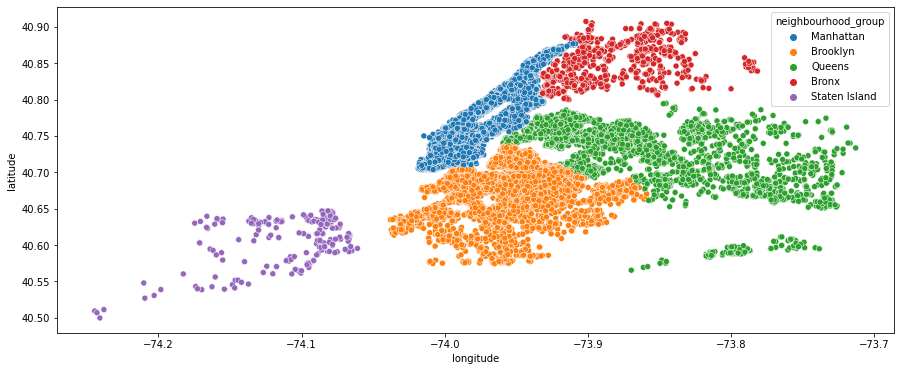

In [14]:
plt.figure(figsize=(15, 6))
sns.scatterplot(train_data_raw.longitude, train_data_raw.latitude,
                hue=train_data_raw.neighbourhood_group)
plt.ioff()

In [15]:
train_data_eda = pd.concat([train_data_norm, train_price.reset_index(drop=True)], axis='columns')
train_data_eda

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,price
0,0.289966,-0.690667,-0.305948,-0.475869,0.235835,-0.738330,-0.187906,-0.856224,0.958908,-0.914525,-0.155431,-0.148608,-0.839674,1.123834,-0.361614,-0.086058,5.164786
1,-0.335356,-0.200971,-0.202917,-0.430833,-0.406824,-0.453552,-0.157792,-0.856224,0.958908,-0.914525,-0.155431,-0.148608,1.190939,-0.889811,-0.361614,-0.086058,5.010635
2,-0.295398,-0.294184,-0.254432,-0.453351,0.092211,-0.774684,-0.187906,-0.734560,0.958908,-0.914525,-0.155431,-0.148608,1.190939,-0.889811,-0.361614,-0.086058,5.298317
3,-0.170371,-0.633004,-0.202917,0.154645,-0.652689,0.237186,-0.157792,0.527711,0.958908,-0.914525,-0.155431,-0.148608,-0.839674,1.123834,-0.361614,-0.086058,5.703782
4,-0.726642,0.574218,-0.254432,-0.408314,-0.623477,0.909747,-0.187906,-0.225089,-1.042853,1.093464,-0.155431,-0.148608,1.190939,-0.889811,-0.361614,-0.086058,4.382027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31281,1.683498,-0.036438,-0.305948,-0.453351,0.674011,-0.786802,-0.187906,-0.856224,-1.042853,1.093464,-0.155431,-0.148608,-0.839674,1.123834,-0.361614,-0.086058,4.174387
31282,0.888036,0.021657,1.239516,-0.408314,-0.375177,-0.592911,0.775759,1.630297,0.958908,-0.914525,-0.155431,-0.148608,-0.839674,1.123834,-0.361614,-0.086058,5.459586
31283,0.275972,-0.572090,-0.254432,-0.363278,-0.650255,-0.059710,-0.187906,0.474483,-1.042853,1.093464,-0.155431,-0.148608,-0.839674,1.123834,-0.361614,-0.086058,4.700480
31284,-0.786670,0.620825,-0.305948,0.424866,-0.545579,1.582307,-0.157792,-0.346754,-1.042853,1.093464,-0.155431,-0.148608,1.190939,-0.889811,-0.361614,-0.086058,4.174387


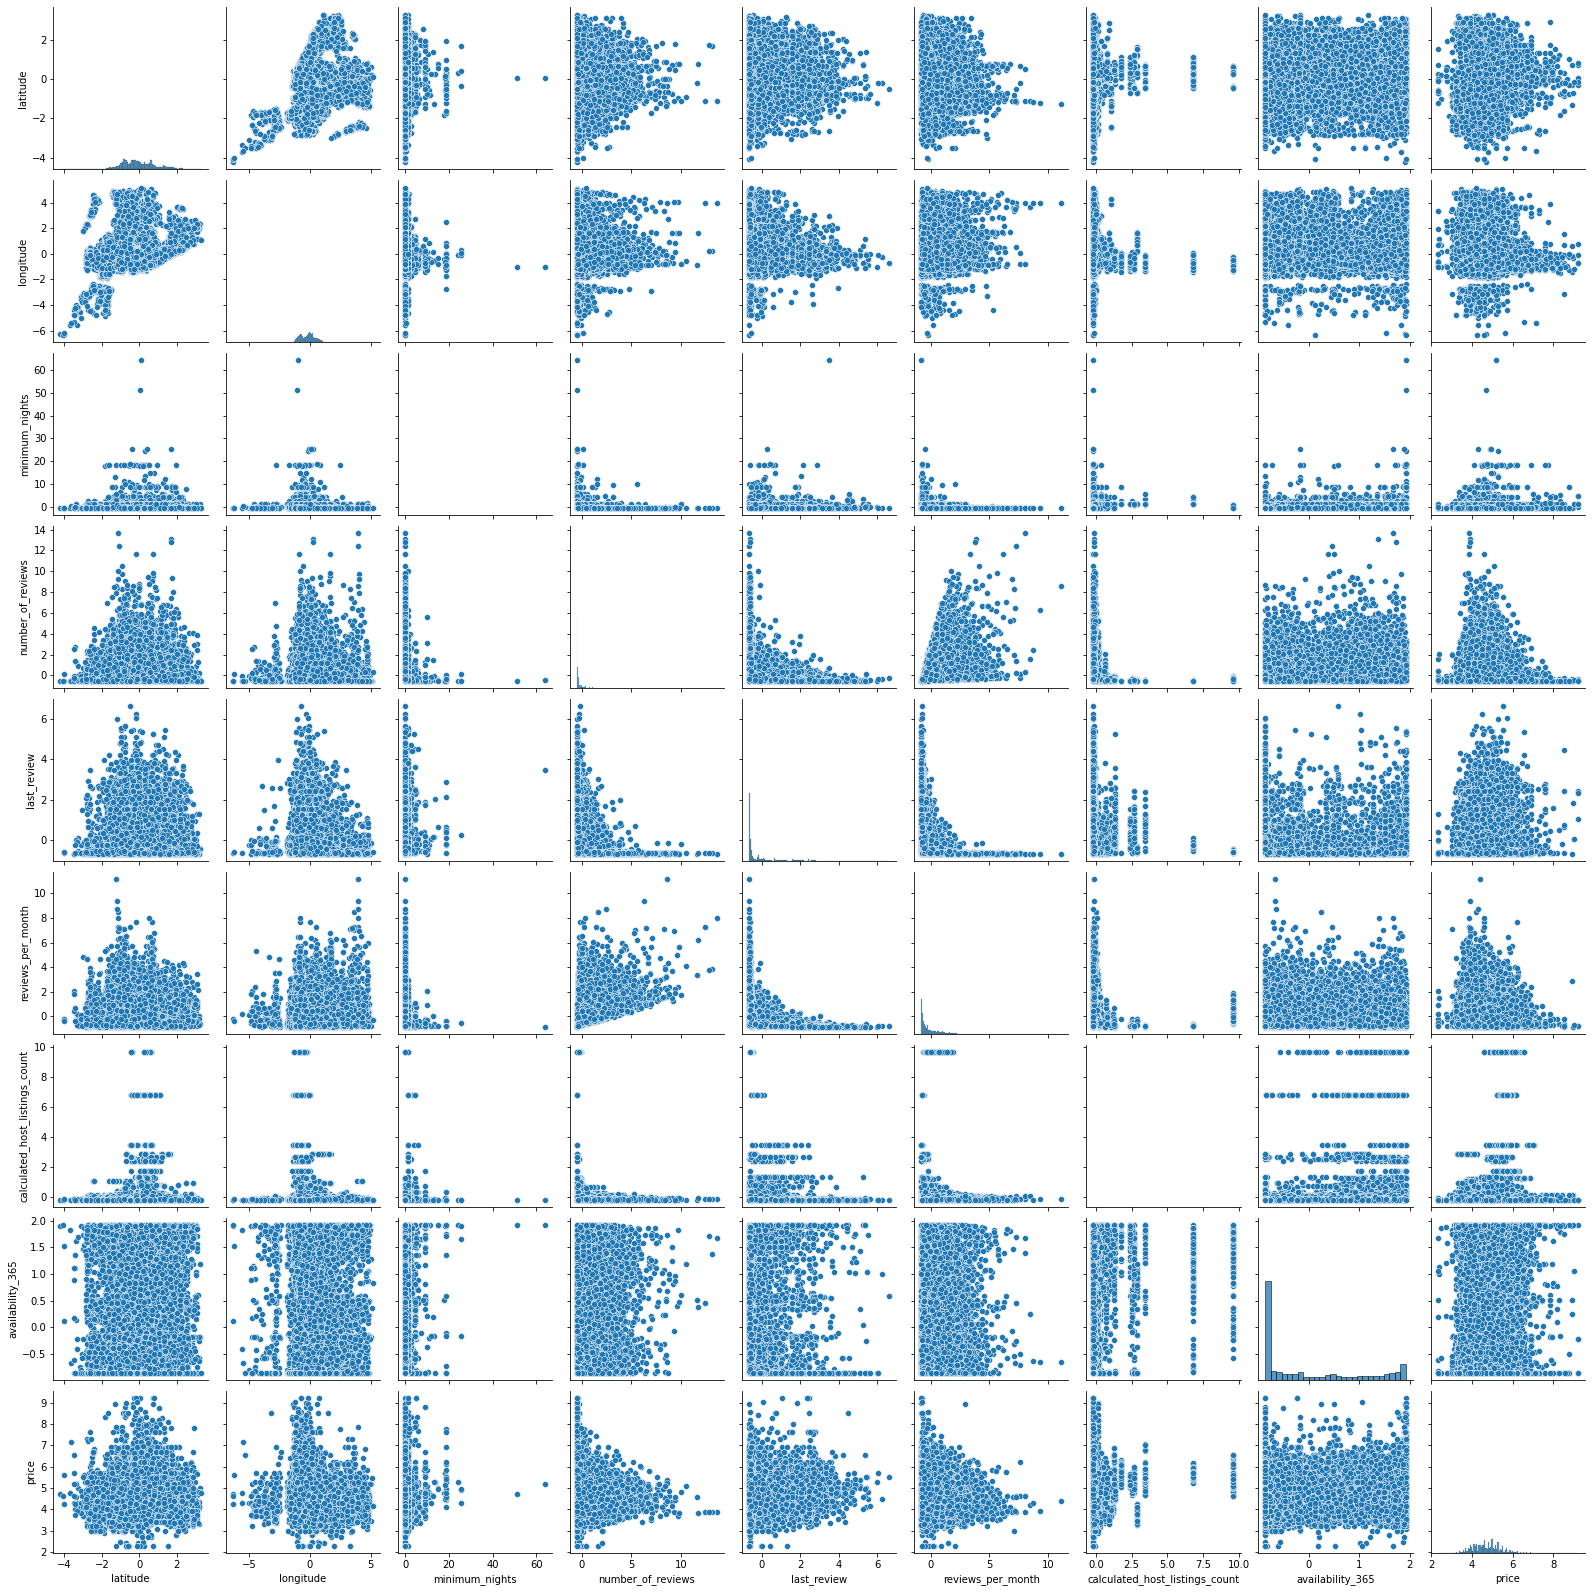

In [16]:
sns.pairplot(train_data_eda[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']])

<AxesSubplot:>

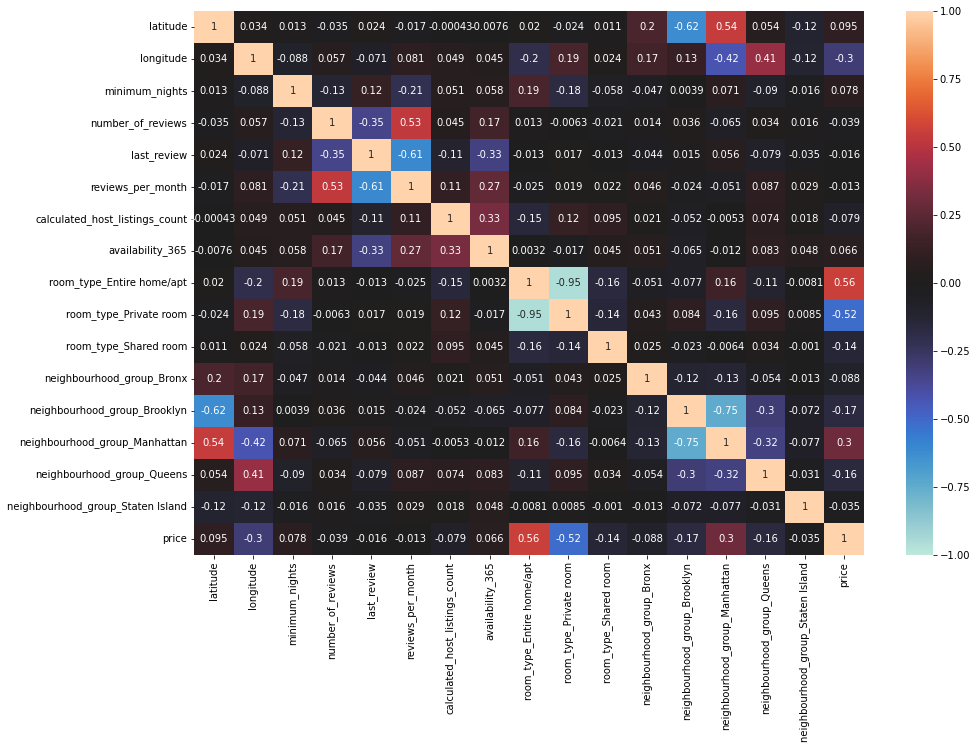

In [17]:
corr = train_data_eda.corr(method='kendall')
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, center=0, vmin=-1, vmax=1)

# Model Training

## Preparing

In [18]:
train_data_norm.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island'],
      dtype='object')

### Select features

In [19]:
selected_features = ['latitude', 'longitude', 'minimum_nights', 'calculated_host_listings_count', 'availability_365','neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'room_type_Entire home/apt', 'room_type_Private room']
X = train_data_norm[selected_features].to_numpy()
Y = train_price

### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Metrics

In [21]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, Y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 0.36535403528943483
MSE: 0.25826483600223493
RMSE: 0.5081976347861479
R2 Square 0.4786217007019138
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3632562949628172
MSE: 0.25084506944586643
RMSE: 0.5008443565079539
R2 Square 0.48830511782096664
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

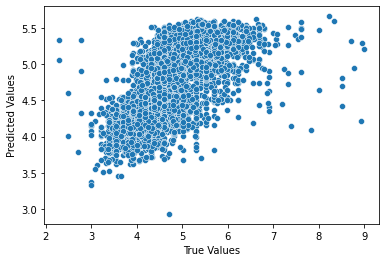

In [23]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

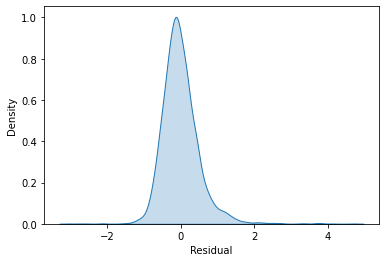

In [24]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Robust Regression - Random Sample Consensus - RANSAC

In [25]:
from sklearn.linear_model import RANSACRegressor

rob_reg = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
rob_reg.fit(X_train, y_train)

test_pred = rob_reg.predict(X_test)
train_pred = rob_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.38624056940594886
MSE: 0.2952190732833688
RMSE: 0.543340660436313
R2 Square 0.4040194525455725
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.38554341573010126
MSE: 0.2879994553489213
RMSE: 0.5366558071510279
R2 Square 0.4125144747794426
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

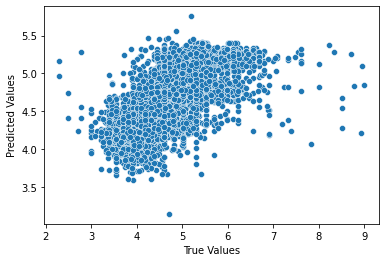

In [26]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

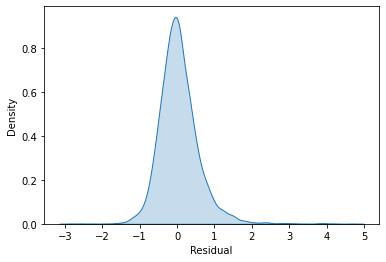

In [27]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Ridge Regression

In [28]:
from sklearn.linear_model import Ridge

rid_reg = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=0)
rid_reg.fit(X_train, y_train)
pred = rid_reg.predict(X_test)

test_pred = rid_reg.predict(X_test)
train_pred = rid_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.3655643737626058
MSE: 0.25853929081057114
RMSE: 0.5084675907180035
R2 Square 0.4780676385097101
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.36359623845008393
MSE: 0.2513506167455389
RMSE: 0.5013487974908675
R2 Square 0.48727385989545413
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

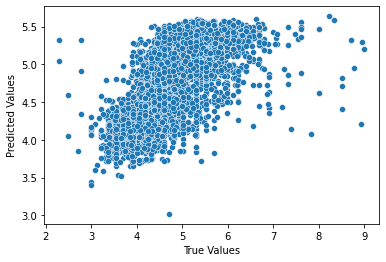

In [29]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

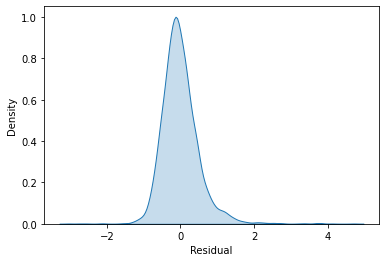

In [30]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## LASSO Regression

In [31]:
from sklearn.linear_model import Lasso

las_reg = Lasso(alpha=0.1, 
              precompute=True, 
              positive=True, 
              selection='random',
              random_state=42)
las_reg.fit(X_train, y_train)

test_pred = las_reg.predict(X_test)
train_pred = las_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.3949961234147466
MSE: 0.29614346010330034
RMSE: 0.5441906468355555
R2 Square 0.4021533245990436
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.39463996660174333
MSE: 0.2898913184689003
RMSE: 0.5384155629891286
R2 Square 0.4086552931801589
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

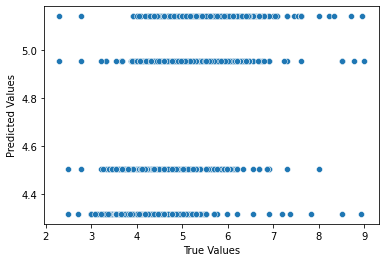

In [32]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

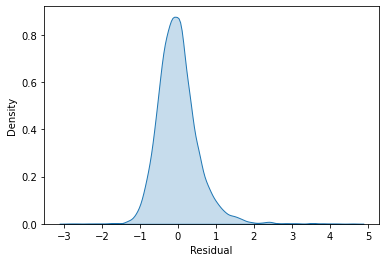

In [33]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Elastic Net

In [34]:
from sklearn.linear_model import ElasticNet

ela_reg = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
ela_reg.fit(X_train, y_train)

test_pred = ela_reg.predict(X_test)
train_pred = ela_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.3888513555060023
MSE: 0.2893350111739964
RMSE: 0.5378986997325764
R2 Square 0.4158980433093664
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3876251305400433
MSE: 0.282286925586096
RMSE: 0.5313068092788723
R2 Square 0.424167373719774
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

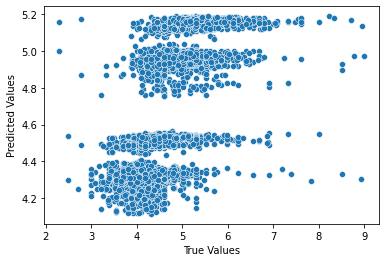

In [35]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

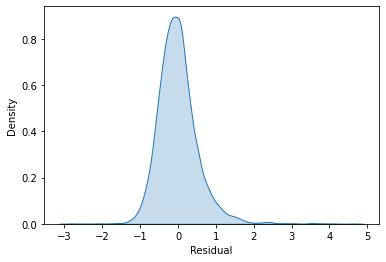

In [36]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Polynomial Regression

In [37]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

pol_reg = LinearRegression(normalize=True)
pol_reg.fit(X_train_2_d,y_train)

test_pred = pol_reg.predict(X_test_2_d)
train_pred = pol_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.34738730674184204
MSE: 0.2389034054266614
RMSE: 0.48877746002312894
R2 Square 0.5177080505965743
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3442479732487253
MSE: 0.22893943083758714
RMSE: 0.4784761549310343
R2 Square 0.5329900828931581
__________________________________


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

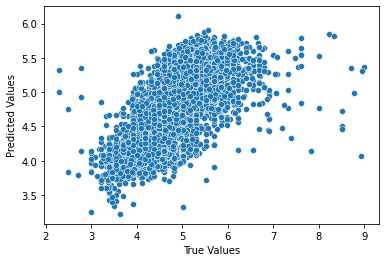

In [38]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

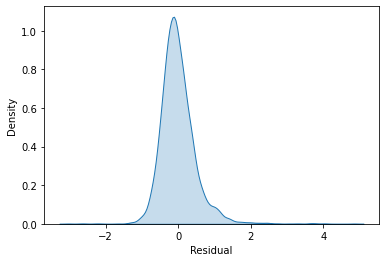

In [39]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Stochastic Gradient Descent

In [40]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.368948103527136
MSE: 0.26350618480191984
RMSE: 0.5133285349577986
R2 Square 0.46804060276574666
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.36750983045739594
MSE: 0.25676434123483843
RMSE: 0.5067191936712467
R2 Square 0.4762304890976091
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

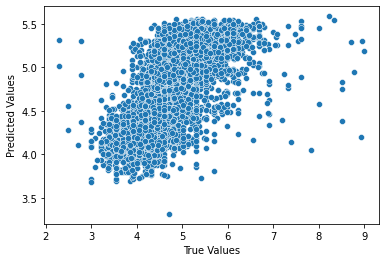

In [41]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

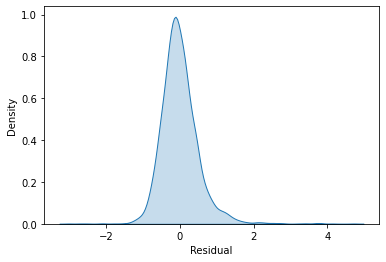

In [42]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 0.32652853646882307
MSE: 0.21768560998715022
RMSE: 0.4665679050118538
R2 Square 0.5605419813490029
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.11959938565291775
MSE: 0.028548112514555708
RMSE: 0.168961867042702
R2 Square 0.9417651576654895
__________________________________


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Values')

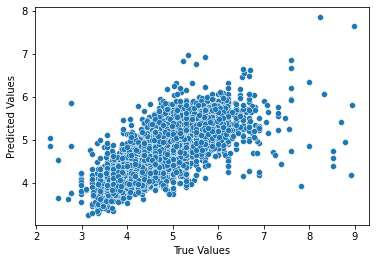

In [44]:
sns.scatterplot(y_test, test_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0.5, 0, 'Residual')

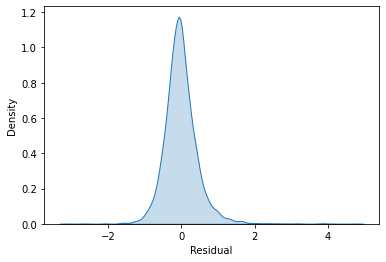

In [45]:
sns.kdeplot(y_test - test_pred, fill=True)
plt.xlabel("Residual")

## Support Vector Machine

In [46]:
# from sklearn.svm import SVR

# svm_reg = SVR(kernel='rbf', C=10000, epsilon=0.001)
# svm_reg.fit(X_train, y_train)

# test_pred = svm_reg.predict(X_test)
# train_pred = svm_reg.predict(X_train)

# print('Test set evaluation:\n_____________________________________')
# print_evaluate(y_test, test_pred)
# print('Train set evaluation:\n_____________________________________')
# print_evaluate(y_train, train_pred)

# results_df_2 = pd.DataFrame(data=[["SVM Regressor", *evaluate(y_test, test_pred), 0]], 
#                             columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
# results_df = results_df.append(results_df_2, ignore_index=True)

In [47]:
# sns.scatterplot(y_test, test_pred)
# plt.xlabel("True Values")
# plt.ylabel("Predicted Values")

In [48]:
# sns.kdeplot(y_test - test_pred, fill=True)
# plt.xlabel("Residual")

# Models Comparison

In [49]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.365354,0.258265,0.508198,0.478622,0.485524
1,Robust Regression,0.386241,0.295219,0.543341,0.404019,0.227733
2,Ridge Regression,0.365564,0.258539,0.508468,0.478068,0.485524
3,Lasso Regression,0.394996,0.296143,0.544191,0.402153,-0.000354
4,Elastic Net Regression,0.388851,0.289335,0.537899,0.415898,-0.000354
5,Polynomail Regression,0.347387,0.238903,0.488777,0.517708,0.000000
6,Stochastic Gradient Descent,0.368948,0.263506,0.513329,0.468041,0.000000
7,Random Forest Regressor,0.326529,0.217686,0.466568,0.560542,0.000000


<AxesSubplot:ylabel='Model'>

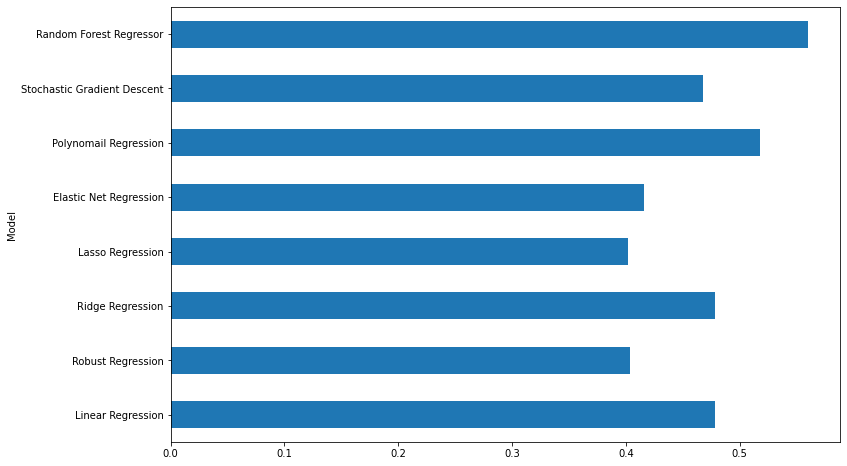

In [50]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

# Submission

In [51]:
rf_reg.fit(X, Y)
pred = rf_reg.predict(test_data_norm[selected_features].to_numpy())
submission = pd.read_csv('../input/1102-mds603-machine-learning/sample_submission.csv')
submission['price'] = np.exp(pred)
submission.to_csv('submission.csv', index=False)
submission

,id,price
0,23839013,108.863984
1,29656859,68.878370
2,16489175,75.253162
3,36312752,87.900824
4,4566340,117.121051
...,...,...
7819,23565653,72.917699
7820,1777197,29.803337
7821,31987512,246.405627
7822,10411679,76.801537
